#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib as mpl

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.dummy import DummyRegressor

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [3]:
display(data.index.is_monotonic)

True

In [4]:
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
В набор данных входят столбцы: <br> 
datetime - дата и время заказа такси, <br>
num_orders - количество заказов такси (целевой признак). <br>
Пропуски в данных отсутствуют.   
</div>

## Анализ

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<b>Разложение временного ряда на компоненты</b>   
</div>

In [6]:
print('-Начальная дата-',data.index.min())
print('-Конечная дата-',data.index.max())
print('-Общее время-',data.index.max() - data.index.min())

-Начальная дата- 2018-03-01 00:00:00
-Конечная дата- 2018-08-31 23:50:00
-Общее время- 183 days 23:50:00


In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<AxesSubplot:xlabel='datetime'>

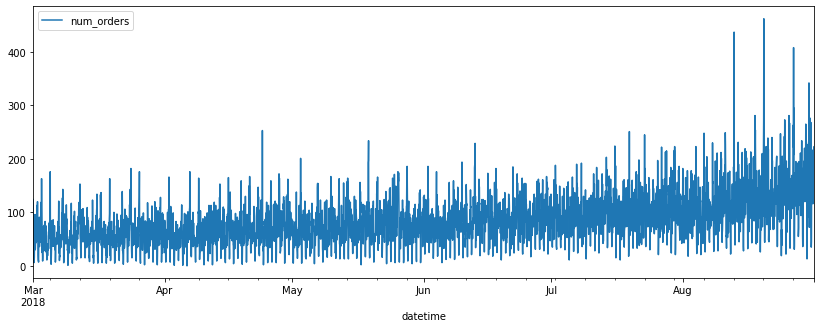

In [8]:
data.resample('1H').sum().plot(figsize=(14, 5))

<AxesSubplot:xlabel='datetime'>

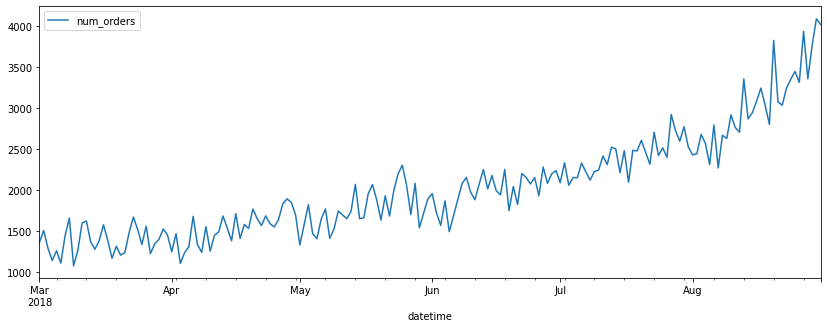

In [9]:
data.resample('1D').sum().plot(figsize=(14, 5))

<AxesSubplot:xlabel='datetime'>

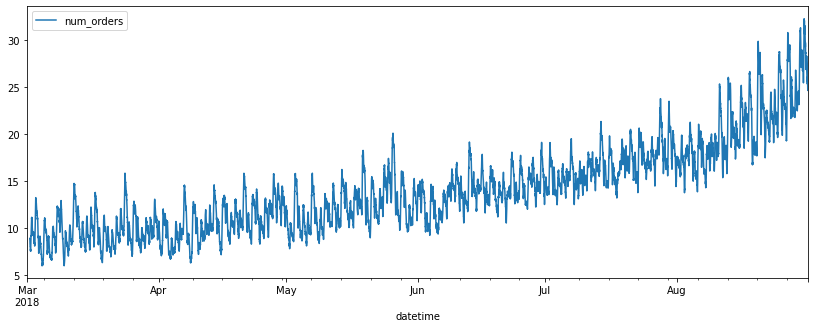

In [10]:
data.rolling(100).mean().plot(figsize=(14, 5))

In [11]:
data = data.resample('1H').sum()

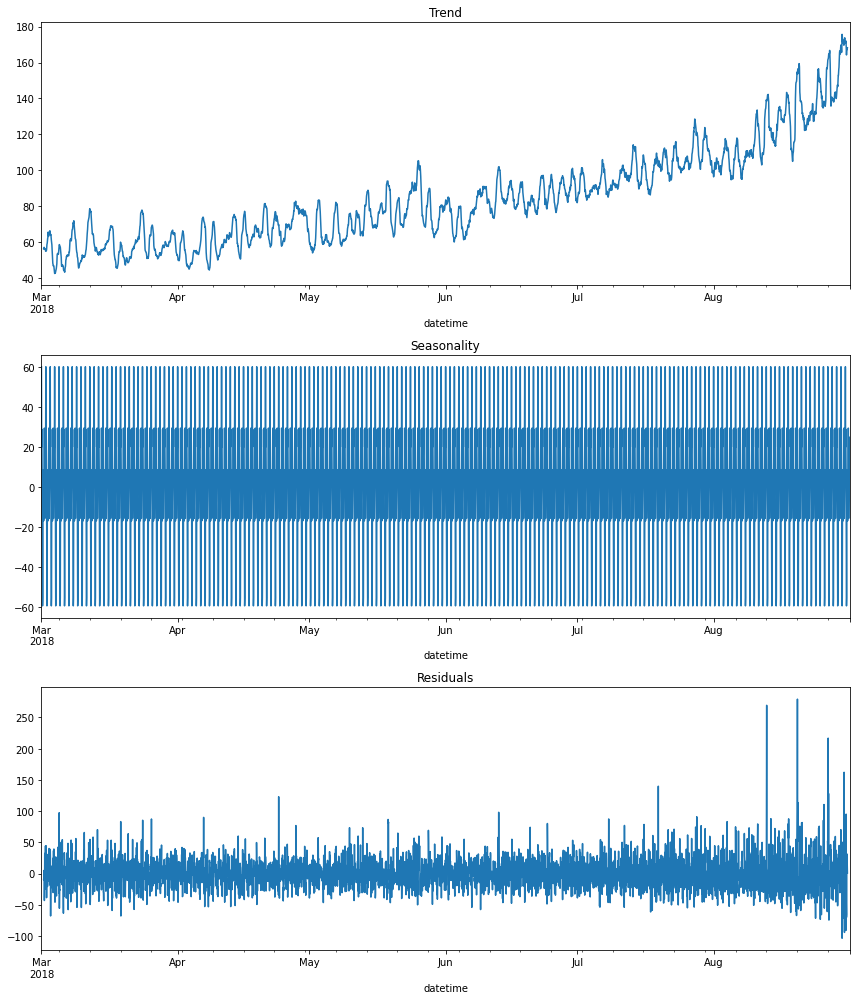

In [12]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 14))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
Проведем анализ данных для недельного интервала.   
</div>

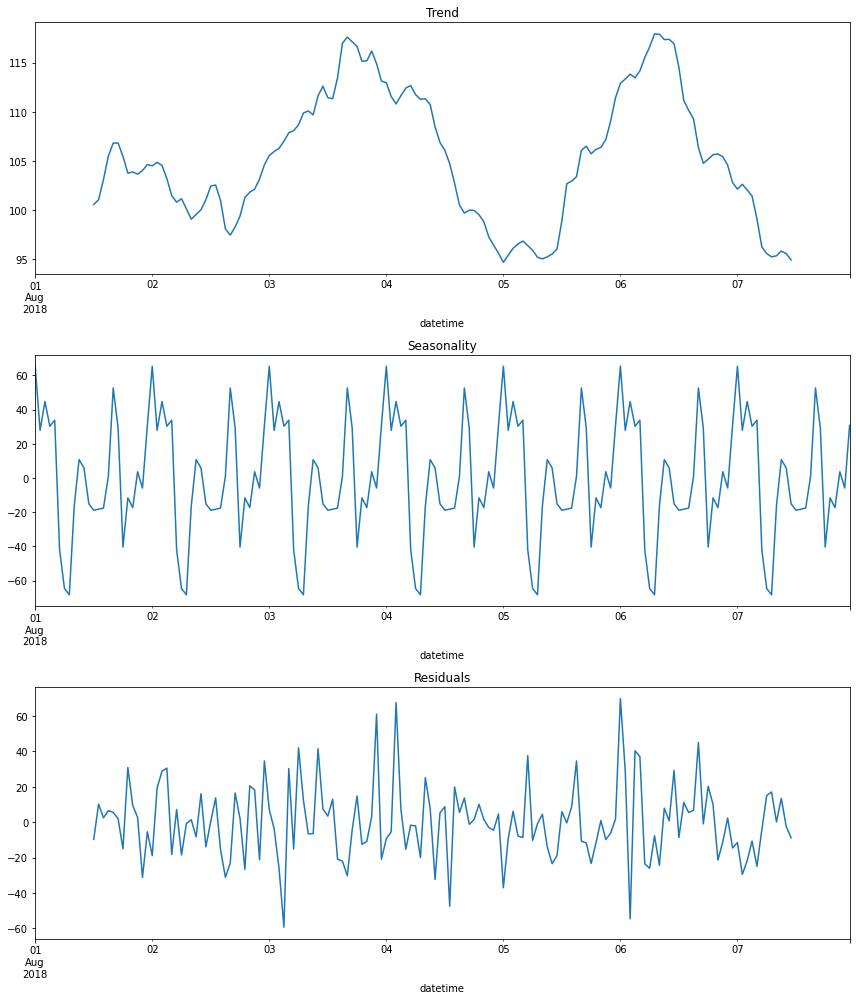

In [13]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-07'])

plt.figure(figsize=(12, 14))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<b>Стационарность</b>   
</div>

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
Для оценки стационарности применим тест Дики-Фуллера (Dickey-Fuller test).    
</div>

In [14]:
result = adfuller(data['num_orders'])

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
Вероятность (p-value) для данных меньше, чем 0,05. Временной ряд можно считать стационарным.    
</div>

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<b>Автокорреляция</b>   
</div>

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
Автокорреляция также показывает степень взаимосвязи в диапазоне от –1 до 1, но только не двух переменных, а одной и той же переменной в разные моменты времени.    
</div>

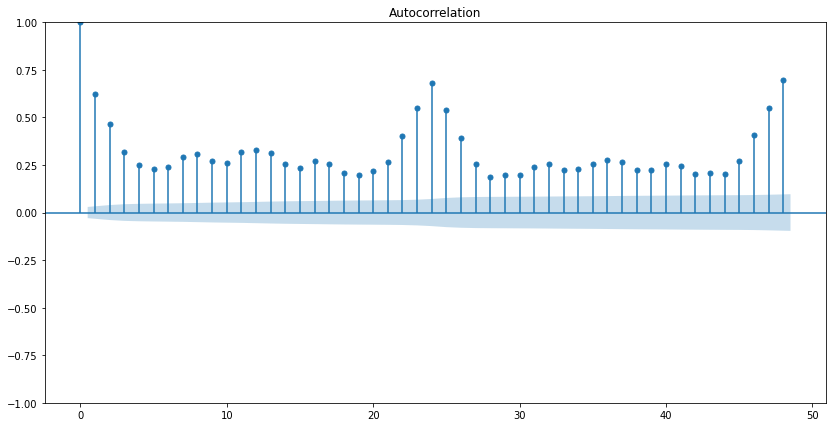

In [15]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))
    plot_acf(data, lags=48)

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
Мы видим, что лаг 24 сильнее коррелирует с исходным рядом, чем соседние лаги 23 и 25. Такая автокорреляция позволяет предположить наличие суточных (часовых) колебаний. <br>
Анализируя графики декомпозиции временного ряда, а также график автокорреляции, выберем окно для формирования признаков предсказательной модели равным 24.    
</div>

## Обучение

In [16]:
def RMSE(y_true,y_pred):
    error = mean_squared_error(y_true, y_pred) ** 0.5 
    return error

In [17]:
score = make_scorer(RMSE,greater_is_better=False)

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1 
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(data, 24, 100)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

In [20]:
features_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_21,lag_22,lag_23,lag_24,year,month,day,weekday,is_weekend,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,...,12.0,11.0,22.0,27.0,2018,3,5,0,0,56.46
2018-03-05 05:00:00,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,...,39.0,12.0,11.0,22.0,2018,3,5,0,0,55.56
2018-03-05 06:00:00,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,...,39.0,39.0,12.0,11.0,2018,3,5,0,0,54.87
2018-03-05 07:00:00,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,19.0,39.0,39.0,12.0,2018,3,5,0,0,54.19
2018-03-05 08:00:00,14.0,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,41.0,19.0,39.0,39.0,2018,3,5,0,0,53.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,...,123.0,81.0,108.0,108.0,2018,8,13,0,0,117.23
2018-08-13 10:00:00,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,...,120.0,123.0,81.0,108.0,2018,8,13,0,0,117.97
2018-08-13 11:00:00,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,...,104.0,120.0,123.0,81.0,2018,8,13,0,0,119.19


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Масштабирование численных признаков</b>
</p>
</div>

In [21]:
num_cols = ['lag_1','lag_2','lag_3','lag_4','lag_5','lag_6','lag_7','lag_8','lag_9','lag_10','lag_11','lag_12','lag_13','lag_14','lag_15','lag_16','lag_17',
            'lag_18','lag_19','lag_20','lag_21','lag_22','lag_23','lag_24','year','month','day','weekday','is_weekend','rolling_mean']
scaler = StandardScaler()
features_train[num_cols] = scaler.fit_transform(features_train[num_cols])

features_test[num_cols] = scaler.transform(features_test[num_cols])

In [22]:
features_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_21,lag_22,lag_23,lag_24,year,month,day,weekday,is_weekend,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,-0.719908,-1.210673,2.511455,0.185892,-0.279188,0.108861,-0.098325,-0.046659,-0.589733,0.031563,...,-1.746057,-1.771544,-1.481710,-1.349469,0.0,-1.467671,-1.192587,-1.493731,-0.631313,-1.225223
2018-03-05 05:00:00,-1.159560,-0.719382,-1.210344,2.513202,0.186406,-0.279137,0.108636,-0.098400,-0.046477,-0.589522,...,-1.036239,-1.745252,-1.770969,-1.480926,0.0,-1.467671,-1.192587,-1.493731,-0.631313,-1.276470
2018-03-05 06:00:00,-1.625075,-1.158958,-0.719273,-1.210493,2.514372,0.186461,-0.279416,0.108564,-0.098215,-0.046072,...,-1.036239,-1.035369,-1.744672,-1.770134,0.0,-1.467671,-1.192587,-1.493731,-0.631313,-1.315759
2018-03-05 07:00:00,-1.961280,-1.624391,-1.158652,-0.719172,-1.210374,2.514454,0.186246,-0.279493,0.108739,-0.097829,...,-1.562030,-1.035369,-1.034675,-1.743842,0.0,-1.467671,-1.192587,-1.493731,-0.631313,-1.354479
2018-03-05 08:00:00,-1.676799,-1.960537,-1.623877,-1.158775,-0.718915,-1.210335,2.514554,0.186175,-0.279301,0.109199,...,-0.983659,-1.561208,-1.034675,-1.033970,0.0,-1.467671,-1.192587,-1.493731,-0.631313,-1.384088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,0.314569,-1.029671,-0.331586,0.108315,1.660784,2.307521,9.266648,5.023950,2.100678,2.748810,...,1.172084,0.068893,0.779763,0.780148,0.0,1.743170,-0.278986,-1.493731,-0.631313,2.235079
2018-08-13 10:00:00,1.504217,0.314914,-1.029423,-0.331287,0.108807,1.660857,2.307594,9.266704,5.023912,2.101847,...,1.093215,1.173154,0.069766,0.780148,0.0,1.743170,-0.278986,-1.493731,-0.631313,2.277216
2018-08-13 11:00:00,1.995593,1.504355,0.314560,-1.029480,-0.330920,0.108861,1.660841,2.307552,9.266482,5.026122,...,0.672582,1.094279,1.174206,0.070276,0.0,1.743170,-0.278986,-1.493731,-0.631313,2.346684


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>RandomForestRegressor</b>
</p>
</div>

In [23]:
model1 = RandomForestRegressor(random_state=577)

In [24]:
param_RF = { 
    'n_estimators': [10,100],
    'max_depth' : [1,10]
    }

In [25]:
%%time
ts_split = TimeSeriesSplit(n_splits=5)
grid_model1 = GridSearchCV(model1,
                           param_grid = param_RF,
                           scoring='neg_mean_squared_error',
                           cv= ts_split)

CPU times: user 44 µs, sys: 28 µs, total: 72 µs
Wall time: 74.1 µs


In [26]:
%%time
grid_model1.fit(features_train,target_train)

CPU times: user 14.1 s, sys: 9.97 ms, total: 14.1 s
Wall time: 14.2 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=577),
             param_grid={'max_depth': [1, 10], 'n_estimators': [10, 100]},
             scoring='neg_mean_squared_error')

In [27]:
print("-Лучшая модель-RandomForestRegressor-")
print(grid_model1.best_estimator_)

-Лучшая модель-RandomForestRegressor-
RandomForestRegressor(max_depth=10, random_state=577)


In [28]:
best_score_model1 = grid_model1.best_score_

In [29]:
print("RandomForestRegressor",best_score_model1)

RandomForestRegressor -691.2827698269766


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>LGBMRegressor</b>
</p>
</div>

In [30]:
%%time
model2 = lgb.LGBMRegressor(objective ='regression',random_state = 577)

params_lgbm = {
    'num_leaves':[10,30],
    'learning_rate':[0.05],     
    'n_estimators':[100,1000],
    'colsample_bytree': [0.3,],
    'subsample': [0.55,],
    'reg_alpha': [0.05,], 
    'reg_lambda': [0],
               } 
ts_split = TimeSeriesSplit(n_splits=5)   
grid_model2 = GridSearchCV(estimator=model2, 
                                param_grid=params_lgbm,
                                verbose = 1, 
                                cv = ts_split,
                                scoring='neg_mean_squared_error', 
                                n_jobs=-1).fit(features_train,target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 8min 10s, sys: 6.21 s, total: 8min 16s
Wall time: 8min 20s


In [31]:
%%time
grid_model2.fit(features_train,target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 3min 2s, sys: 2.26 s, total: 3min 4s
Wall time: 3min 6s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(objective='regression', random_state=577),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3], 'learning_rate': [0.05],
                         'n_estimators': [100, 1000], 'num_leaves': [10, 30],
                         'reg_alpha': [0.05], 'reg_lambda': [0],
                         'subsample': [0.55]},
             scoring='neg_mean_squared_error', verbose=1)

In [32]:
print("-Лучшая модель-LGBMRegressor-")
print(grid_model2.best_estimator_)

-Лучшая модель-LGBMRegressor-
LGBMRegressor(colsample_bytree=0.3, learning_rate=0.05, n_estimators=1000,
              num_leaves=30, objective='regression', random_state=577,
              reg_alpha=0.05, reg_lambda=0, subsample=0.55)


In [33]:
best_score_model2 = grid_model2.best_score_

In [34]:
print("LGBMRegressor",best_score_model2)

LGBMRegressor -680.432004069243


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>XGBRegressor</b>
</p>
</div>

In [35]:
model3 = XGBRegressor(random_state=577) 

In [36]:
param_set = {"learning_rate": [0.05,], 
                        "max_depth": [ 3, 4, 5, 7],
                        "min_child_weight": [1],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[0.3],}

In [37]:
%%time
ts_split = TimeSeriesSplit(n_splits=5)
grid_model3 = GridSearchCV(estimator=model3,
                           param_grid=param_set,
                           cv=ts_split, 
                           scoring='neg_mean_squared_error', 
                           verbose=0, 
                           n_jobs=-1)

CPU times: user 58 µs, sys: 1 µs, total: 59 µs
Wall time: 61.8 µs


In [ ]:
%%time
grid_model3.fit(features_train,target_train)

In [ ]:
print("-Лучшая модель-XGBRegressor-")
print(grid_model3.best_estimator_)

In [ ]:
best_score_model3 = grid_model3.best_score_

In [ ]:
print("XGBRegressor",best_score_model3)

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Обучим константную модель и оценим адекватность нашей модели</b>
</p>
</div>

In [ ]:
model4 = DummyRegressor(strategy="median")

In [ ]:
model4.fit(features_train,target_train)

In [ ]:
predicted_test = model4.predict(features_test)

In [ ]:
print('-Оценка Константной модели-')
rmse_val = RMSE(target_test,predicted_test)
print('-RMSE на тестовой выборке-',rmse_val)

## Тестирование

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Обучили и исследовали три модели: RandomForestRegressor, LGBMRegressor, XGBRegressor. Для оценки качества моделей обучили константную модель DummyRegressor. Самые лучшие результаты по качеству предсказания показала модель: LGBMRegressor с результатам кросс-валидации: 680. Протестируем эту лучшую модель и построим графики исходного и предсказанных рядов.
</p>
</div>

In [ ]:
%%time
predicted_test = grid_model2.predict(features_test)

In [ ]:
print('-LGBMRegressor-')
rmse_val = RMSE(target_test,predicted_test)
print('-RMSE на тестовой выборке-',rmse_val)

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(predicted_test, "r", label="predicted")
plt.plot(target_test.values, label="actual")
plt.legend(loc="best")
plt.title("LGBMRegressor")
plt.grid(True);

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Результаты предсказания лучшей модели LGBMRegressor на тестовой выборке: -RMSE на тестовой выборке- 40.89. Цель проекта достигнула, получено RMSE на тестовой выборке, меньше 48.
</p>
</div>

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Обучили констрантную модель DummyRegressor. Результат: -Оценка Константной модели-
-RMSE на тестовой выборке- 87.15. Это значение является намного худшим результатом, чем результат полученной лучшей модели LGBMRegressor на тестовой выборке 40.89. 
</p>
</div>